> ⚠️ Kaggle API key and download commands were removed for security.  
> Please download the dataset manually from [FER2013 on Kaggle](https://www.kaggle.com/datasets/msambare/fer2013) and place it in the working directory.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import precision_recall_fscore_support
import numpy as np



In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
# Enhanced transformations for better augmentation
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.RandomCrop(224),     # Random crop to target size
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


### Dataset Setup

Make sure you have the `train/` and `test/` folders extracted from the FER2013 dataset  
and placed in the current working directory like this:



In [ ]:
# Directories for training and validation data
train_dir = './train'
test_dir = './test'

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_transforms)

# Split train_dataset into train and validation datasets
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)  # Validation loader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f'Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}, Test samples: {len(test_dataset)}')


Training samples: 22967, Validation samples: 5742, Test samples: 7178


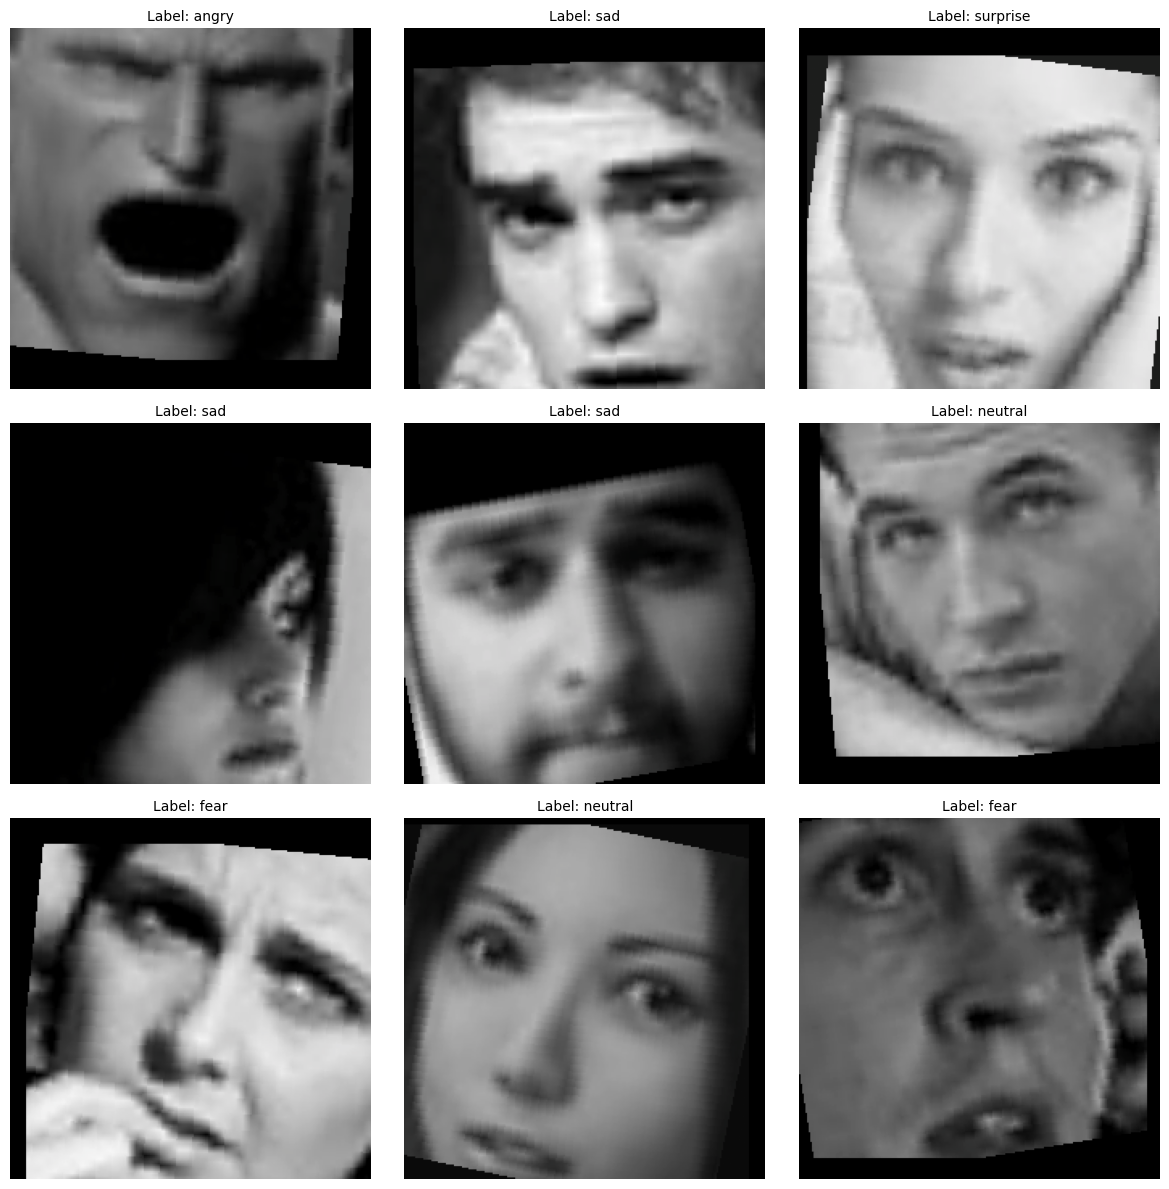

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms

# Function to unnormalize the image properly (reverse the normalization process)
def imshow(tensor):
    # Reverse the normalization process (unnormalize)
    unnormalize = transforms.Compose([
        transforms.Normalize(mean=[0., 0., 0.], std=[1./0.229, 1./0.224, 1./0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.])
    ])
    tensor = unnormalize(tensor)

    # Convert the tensor to numpy and permute it from CxHxW to HxWxC
    image = tensor.permute(1, 2, 0).numpy()

    # Clip to the range [0, 1] for proper display
    image = np.clip(image, 0, 1)

    # Show the image using matplotlib
    plt.imshow(image)
    plt.axis('off')

# Load a batch from the train_loader (you can also use val_loader or test_loader)
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Get the class names from the dataset
class_names = train_dataset.dataset.classes  # Adjusted for your setup

# Display some images
plt.figure(figsize=(12, 12))
for i in range(9):  # Display 9 images
    ax = plt.subplot(3, 3, i+1)
    imshow(images[i])  # Display image
    label = labels[i].item()  # Get the label
    ax.set_title(f'Label: {class_names[label]}', fontsize=10)
plt.tight_layout()
plt.show()


In [7]:
# Calculate class weights for imbalanced dataset
class_counts = torch.zeros(len(train_dataset.dataset.classes))
for _, label in train_dataset:
    class_counts[label] += 1
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum()
class_weights = class_weights.to(device)


In [8]:
weights = torchvision.models.VGG19_Weights.DEFAULT
model = torchvision.models.vgg19( weights=weights)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 78.1MB/s]


In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary

summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=18,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape        Output Shape       Param #            Trainable
VGG (VGG)                                [32, 3, 224, 224]  [32, 7]            --                 Partial
├─Sequential (features)                  [32, 3, 224, 224]  [32, 512, 7, 7]    --                 Partial
│    └─Conv2d (0)                        [32, 3, 224, 224]  [32, 64, 224, 224] (1,792)            False
│    └─ReLU (1)                          [32, 64, 224, 224] [32, 64, 224, 224] --                 --
│    └─Conv2d (2)                        [32, 64, 224, 224] [32, 64, 224, 224] (36,928)           False
│    └─ReLU (3)                          [32, 64, 224, 224] [32, 64, 224, 224] --                 --
│    └─MaxPool2d (4)                     [32, 64, 224, 224] [32, 64, 112, 112] --                 --
│    └─Conv2d (5)                        [32, 64, 112, 112] [32, 128, 112, 112] (73,856)           False
│    └─ReLU (6)                          [32, 128, 112, 112] [32

In [ ]:
# Freeze all parameters in the feature layers
for param in model.features.parameters():
    param.requires_grad = False

# Unfreeze only the last 12 layers of the feature layers
for param in model.features[-12:].parameters():
    param.requires_grad = True



# Modify the classifier
model.classifier = nn.Sequential(
    # First block 
    nn.Sequential(
        nn.Linear(512 * 7 * 7, 4096),
        nn.BatchNorm1d(4096),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(4096, 4096),
        nn.BatchNorm1d(4096),
        nn.ReLU()
    ),

    # Second block 
    nn.Sequential(
        nn.Linear(4096, 2048),
        nn.BatchNorm1d(2048),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(2048, 2048),
        nn.BatchNorm1d(2048),
        nn.ReLU(),
        
    ),

    # Third block 
    nn.Sequential(
        nn.Linear(2048, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(1024, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        
    ),

    # Fourth block 
    nn.Sequential(
        nn.Linear(1024, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        
    ),

    # Fifth block 
    nn.Sequential(
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        
    ),

    # Final classification layer
    nn.Linear(256, 7)  # 7 emotion classes
)

model = model.to(device)



In [ ]:
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=18,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape        Output Shape       Param #            Trainable
VGG (VGG)                                [32, 3, 224, 224]  [32, 7]            --                 Partial
├─Sequential (features)                  [32, 3, 224, 224]  [32, 512, 7, 7]    --                 Partial
│    └─Conv2d (0)                        [32, 3, 224, 224]  [32, 64, 224, 224] (1,792)            False
│    └─ReLU (1)                          [32, 64, 224, 224] [32, 64, 224, 224] --                 --
│    └─Conv2d (2)                        [32, 64, 224, 224] [32, 64, 224, 224] (36,928)           False
│    └─ReLU (3)                          [32, 64, 224, 224] [32, 64, 224, 224] --                 --
│    └─MaxPool2d (4)                     [32, 64, 224, 224] [32, 64, 112, 112] --                 --
│    └─Conv2d (5)                        [32, 64, 112, 112] [32, 128, 112, 112] (73,856)           False
│    └─ReLU (6)                          [32, 128, 112, 112] [32

In [ ]:
from torch.optim import AdamW

# Loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)


optimizer = AdamW([
    {'params': model.features[-12:].parameters(), 'lr': 2e-5},
    {'params': model.classifier.parameters(), 'lr': 2e-4}
], weight_decay=0.01)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=3,
    min_lr=1e-6,
    verbose=True
)


In [11]:
def accuracy(output, target):
    _, pred = torch.max(output, 1)
    correct = pred.eq(target).sum().item()
    return correct / len(target)

def precision_recall(output, target):
    _, pred = torch.max(output, 1)
    precision, recall, _, _ = precision_recall_fscore_support(
        target.cpu().numpy(),
        pred.cpu().numpy(),
        average='weighted',
        zero_division=0
    )
    return precision, recall

# Gradient clipping function
def clip_gradient(optimizer, grad_clip=1.0):
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)


In [ ]:
import json

# Initialize lists for tracking metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 20
best_val_loss = float('inf')
early_stopping_patience = 5
epochs_without_improvement = 0
best_model_path = 'emotion_model.pth'
metrics_path = 'emotion_training_metrics.json'

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch + 1}/{num_epochs}')
    print('-' * 10)

    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0
    running_precision = 0.0
    running_recall = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            clip_gradient(optimizer)  # Gradient clipping
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += accuracy(outputs, labels) * inputs.size(0)
        batch_precision, batch_recall = precision_recall(outputs, labels)
        running_precision += batch_precision * inputs.size(0)
        running_recall += batch_recall * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset)
    epoch_precision = running_precision / len(train_dataset)
    epoch_recall = running_recall / len(train_dataset)

    print(f'Training - Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Precision: {epoch_precision:.4f} Recall: {epoch_recall:.4f}')

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    val_running_precision = 0.0
    val_running_recall = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
            val_running_corrects += accuracy(outputs, labels) * inputs.size(0)
            batch_precision, batch_recall = precision_recall(outputs, labels)
            val_running_precision += batch_precision * inputs.size(0)
            val_running_recall += batch_recall * inputs.size(0)

    val_loss = val_running_loss / len(val_dataset)
    val_acc = val_running_corrects / len(val_dataset)
    val_precision = val_running_precision / len(val_dataset)
    val_recall = val_running_recall / len(val_dataset)

    print(f'Validation - Loss: {val_loss:.4f} Acc: {val_acc:.4f} Precision: {val_precision:.4f} Recall: {val_recall:.4f}')

    # Save the metrics to a file after each epoch
    train_losses.append(epoch_loss)
    val_losses.append(val_loss)
    train_accuracies.append(epoch_acc)
    val_accuracies.append(val_acc)

    with open(metrics_path, 'w') as f:
        json.dump({
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accuracies': train_accuracies,
            'val_accuracies': val_accuracies
        }, f)

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Early stopping and model checkpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), best_model_path)
        print(f'Saved best model with validation loss: {val_loss:.4f}')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= early_stopping_patience:
        print(f'Early stopping triggered after {epoch + 1} epochs')
        break

print('Training completed')



Epoch 1/20
----------
Training - Loss: 2.0373 Acc: 0.2118 Precision: 0.3225 Recall: 0.2118
Validation - Loss: 1.8689 Acc: 0.3908 Precision: 0.4375 Recall: 0.3908
Saved best model with validation loss: 1.8689

Epoch 2/20
----------
Training - Loss: 1.8313 Acc: 0.4137 Precision: 0.4794 Recall: 0.4137
Validation - Loss: 1.7385 Acc: 0.4700 Precision: 0.5040 Recall: 0.4700
Saved best model with validation loss: 1.7385

Epoch 3/20
----------
Training - Loss: 1.7704 Acc: 0.4625 Precision: 0.5388 Recall: 0.4625
Validation - Loss: 1.7041 Acc: 0.4925 Precision: 0.5710 Recall: 0.4925
Saved best model with validation loss: 1.7041

Epoch 4/20
----------
Training - Loss: 1.7332 Acc: 0.4856 Precision: 0.5675 Recall: 0.4856
Validation - Loss: 1.6737 Acc: 0.5143 Precision: 0.5765 Recall: 0.5143
Saved best model with validation loss: 1.6737

Epoch 5/20
----------
Training - Loss: 1.6934 Acc: 0.5140 Precision: 0.5967 Recall: 0.5140
Validation - Loss: 1.6556 Acc: 0.5331 Precision: 0.5929 Recall: 0.5331
S

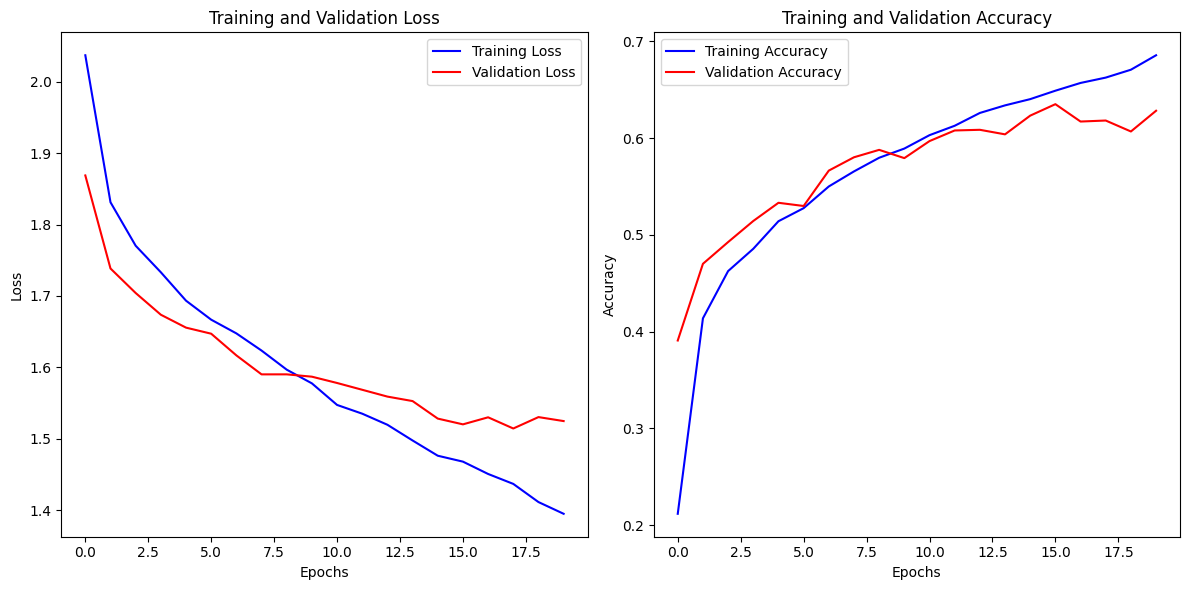

In [ ]:
import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()


In [ ]:
model.eval()
test_running_loss = 0.0
test_running_corrects = 0
test_running_precision = 0.0
test_running_recall = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_running_loss += loss.item() * inputs.size(0)
        test_running_corrects += accuracy(outputs, labels) * inputs.size(0)
        batch_precision, batch_recall = precision_recall(outputs, labels)
        test_running_precision += batch_precision * inputs.size(0)
        test_running_recall += batch_recall * inputs.size(0)

    test_loss = test_running_loss / len(test_dataset)
    test_acc = test_running_corrects / len(test_dataset)
    test_precision = test_running_precision / len(test_dataset)
    test_recall = test_running_recall / len(test_dataset)

print(f' Test - Loss: {test_loss:.4f} Acc: {test_acc:.4f} Precision: {test_precision:.4f} Recall: {test_recall:.4f}')

 Test - Loss: 1.6599 Acc: 0.6166 Precision: 0.9986 Recall: 0.6166


In [ ]:
# Unfreeze only the last 20 layers of the feature layers for fine tuning
for param in model.features[-20:].parameters():
    param.requires_grad = True



In [ ]:
from torchinfo import summary

summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=18,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape        Output Shape       Param #            Trainable
VGG (VGG)                                [32, 3, 224, 224]  [32, 7]            --                 Partial
├─Sequential (features)                  [32, 3, 224, 224]  [32, 512, 7, 7]    --                 Partial
│    └─Conv2d (0)                        [32, 3, 224, 224]  [32, 64, 224, 224] (1,792)            False
│    └─ReLU (1)                          [32, 64, 224, 224] [32, 64, 224, 224] --                 --
│    └─Conv2d (2)                        [32, 64, 224, 224] [32, 64, 224, 224] (36,928)           False
│    └─ReLU (3)                          [32, 64, 224, 224] [32, 64, 224, 224] --                 --
│    └─MaxPool2d (4)                     [32, 64, 224, 224] [32, 64, 112, 112] --                 --
│    └─Conv2d (5)                        [32, 64, 112, 112] [32, 128, 112, 112] (73,856)           False
│    └─ReLU (6)                          [32, 128, 112, 112] [32

In [15]:
fine_tune_optimizer = AdamW([
        {'params': model.features[-20:].parameters(), 'lr': 1e-5},  # Fine-tuning lower learning rate
        {'params': model.classifier.parameters(), 'lr': 1e-4}  # Higher learning rate for the classifier
    ], weight_decay=0.01)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=3,
    min_lr=1e-6,
    verbose=True
)


In [ ]:
import json

# Initialize lists for tracking metrics
fine_tune_train_losses = []
fine_tune_val_losses = []
fine_tune_train_accuracies = []
fine_tune_val_accuracies = []

fine_tune_num_epochs = 30
fine_tune_best_val_loss = float('inf')
fine_tune_early_stopping_patience = 5
fine_tune_epochs_without_improvement = 0
fine_tune_best_model_path = 'emotion_model_fine_tuned.pth'
fine_tune_metrics_path = 'fine_tuned_emotion_training_metrics.json'

for epoch in range(fine_tune_num_epochs):
    print(f'\nFine-Tune Epoch {epoch + 1}/{fine_tune_num_epochs}')
    print('-' * 10)

    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0
    running_precision = 0.0
    running_recall = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        fine_tune_optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            clip_gradient(fine_tune_optimizer)  # Gradient clipping
            fine_tune_optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += accuracy(outputs, labels) * inputs.size(0)
        batch_precision, batch_recall = precision_recall(outputs, labels)
        running_precision += batch_precision * inputs.size(0)
        running_recall += batch_recall * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset)
    epoch_precision = running_precision / len(train_dataset)
    epoch_recall = running_recall / len(train_dataset)

    print(f'Fine-tuning Training - Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Precision: {epoch_precision:.4f} Recall: {epoch_recall:.4f}')

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    val_running_precision = 0.0
    val_running_recall = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
            val_running_corrects += accuracy(outputs, labels) * inputs.size(0)
            batch_precision, batch_recall = precision_recall(outputs, labels)
            val_running_precision += batch_precision * inputs.size(0)
            val_running_recall += batch_recall * inputs.size(0)

    val_loss = val_running_loss / len(val_dataset)
    val_acc = val_running_corrects / len(val_dataset)
    val_precision = val_running_precision / len(val_dataset)
    val_recall = val_running_recall / len(val_dataset)

    print(f'Fine-tuning Validation - Loss: {val_loss:.4f} Acc: {val_acc:.4f} Precision: {val_precision:.4f} Recall: {val_recall:.4f}')

    # Save the metrics to a file after each epoch
    fine_tune_train_losses.append(epoch_loss)
    fine_tune_val_losses.append(val_loss)
    fine_tune_train_accuracies.append(epoch_acc)
    fine_tune_val_accuracies.append(val_acc)

    with open(fine_tune_metrics_path, 'w') as f:
        json.dump({
            'fine_tune_train_losses': fine_tune_train_losses,
            'fine_tune_val_losses': fine_tune_val_losses,
            'fine_tune_train_accuracies': fine_tune_train_accuracies,
            'fine_tune_val_accuracies': fine_tune_val_accuracies
        }, f)

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Early stopping and model checkpoint
    if val_loss < fine_tune_best_val_loss:
        fine_tune_best_val_loss = val_loss
        fine_tune_epochs_without_improvement = 0
        torch.save(model.state_dict(), fine_tune_best_model_path)
        print(f'Saved best model with validation loss: {val_loss:.4f}')
    else:
        fine_tune_epochs_without_improvement += 1

    if fine_tune_epochs_without_improvement >= fine_tune_early_stopping_patience:
        print(f'Early stopping triggered after {epoch + 1} epochs')
        break

print('Fine-tuning completed')



Fine-Tune Epoch 1/30
----------
Fine-tuning Training - Loss: 1.4184 Acc: 0.6690 Precision: 0.7306 Recall: 0.6690
Fine-tuning Validation - Loss: 1.3667 Acc: 0.7045 Precision: 0.7402 Recall: 0.7045
Saved best model with validation loss: 1.3667

Fine-Tune Epoch 2/30
----------
Fine-tuning Training - Loss: 1.3828 Acc: 0.6808 Precision: 0.7416 Recall: 0.6808
Fine-tuning Validation - Loss: 1.3742 Acc: 0.6947 Precision: 0.7321 Recall: 0.6947

Fine-Tune Epoch 3/30
----------
Fine-tuning Training - Loss: 1.3624 Acc: 0.6892 Precision: 0.7501 Recall: 0.6892
Fine-tuning Validation - Loss: 1.3725 Acc: 0.6964 Precision: 0.7354 Recall: 0.6964

Fine-Tune Epoch 4/30
----------
Fine-tuning Training - Loss: 1.3518 Acc: 0.6966 Precision: 0.7578 Recall: 0.6966
Fine-tuning Validation - Loss: 1.3752 Acc: 0.6916 Precision: 0.7286 Recall: 0.6916

Fine-Tune Epoch 5/30
----------
Fine-tuning Training - Loss: 1.3275 Acc: 0.7096 Precision: 0.7667 Recall: 0.7096
Fine-tuning Validation - Loss: 1.3656 Acc: 0.7109 Pr

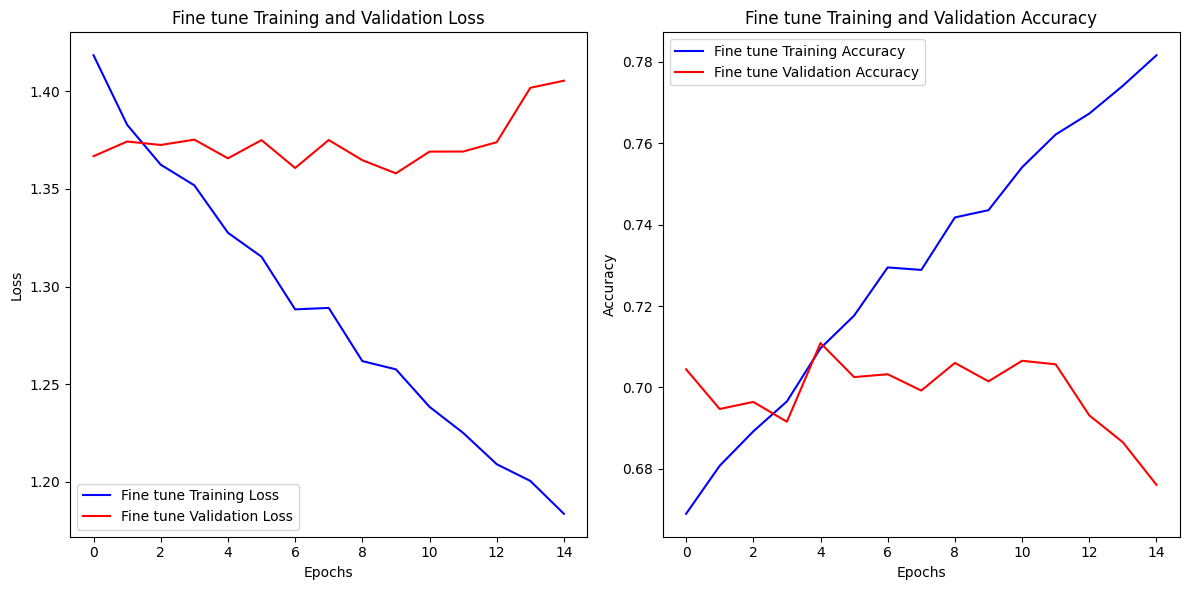

In [ ]:
import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fine_tune_train_losses, label='Fine tune Training Loss', color='blue')
plt.plot(fine_tune_val_losses, label='Fine tune Validation Loss', color='red')
plt.title('Fine tune Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(fine_tune_train_accuracies, label='Fine tune Training Accuracy', color='blue')
plt.plot(fine_tune_val_accuracies, label='Fine tune Validation Accuracy', color='red')
plt.title('Fine tune Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()

In [ ]:
model.eval()
fine_tune_test_running_loss = 0.0
fine_tune_test_running_corrects = 0
fine_tune_test_running_precision = 0.0
fine_tune_test_running_recall = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        fine_tune_test_running_loss += loss.item() * inputs.size(0)
        fine_tune_test_running_corrects += accuracy(outputs, labels) * inputs.size(0)
        batch_precision, batch_recall = precision_recall(outputs, labels)
        fine_tune_test_running_precision += batch_precision * inputs.size(0)
        fine_tune_test_running_recall += batch_recall * inputs.size(0)

    test_loss = fine_tune_test_running_loss / len(test_dataset)
    test_acc = fine_tune_test_running_corrects / len(test_dataset)
    test_precision = fine_tune_test_running_precision / len(test_dataset)
    test_recall = fine_tune_test_running_recall / len(test_dataset)

print(f'Fine-tuning Test - Loss: {test_loss:.4f} Acc: {test_acc:.4f} Precision: {test_precision:.4f} Recall: {test_recall:.4f}')

Fine-tuning Test - Loss: 1.6501 Acc: 0.6388 Precision: 0.9988 Recall: 0.6388


In [ ]:
# Freeze all parameters in the feature layers for second fine tuning
for param in model.features.parameters():
    param.requires_grad = True


In [ ]:
from torchinfo import summary

summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=18,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape        Output Shape       Param #            Trainable
VGG (VGG)                                [32, 3, 224, 224]  [32, 7]            --                 True
├─Sequential (features)                  [32, 3, 224, 224]  [32, 512, 7, 7]    --                 True
│    └─Conv2d (0)                        [32, 3, 224, 224]  [32, 64, 224, 224] 1,792              True
│    └─ReLU (1)                          [32, 64, 224, 224] [32, 64, 224, 224] --                 --
│    └─Conv2d (2)                        [32, 64, 224, 224] [32, 64, 224, 224] 36,928             True
│    └─ReLU (3)                          [32, 64, 224, 224] [32, 64, 224, 224] --                 --
│    └─MaxPool2d (4)                     [32, 64, 224, 224] [32, 64, 112, 112] --                 --
│    └─Conv2d (5)                        [32, 64, 112, 112] [32, 128, 112, 112] 73,856             True
│    └─ReLU (6)                          [32, 128, 112, 112] [32, 128, 11

In [18]:
second_fine_tune_optimizer = AdamW([
        {'params': model.features.parameters(), 'lr': 1e-7},  # Fine-tuning lower learning rate
        {'params': model.classifier.parameters(), 'lr': 1e-6}  # Higher learning rate for the classifier
    ], weight_decay=0.01)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=3,
    min_lr=1e-8,
    verbose=True
)


In [ ]:
import json
import os


# Initialize lists for tracking metrics
second_fine_tune_train_losses = []
second_fine_tune_val_losses = []
second_fine_tune_train_accuracies = []
second_fine_tune_val_accuracies = []

second_fine_tune_num_epochs = 10
second_fine_tune_best_val_loss = float('inf')
second_fine_tune_early_stopping_patience = 5
second_fine_tune_epochs_without_improvement = 0
second_fine_tune_checkpoint_path = 'second_fine_tuned_emotion_checkpoint.pth'
second_fine_tune_metrics_path = 'second_fine_tuned_emotion_training_metrics.json'

# Check if there's a saved checkpoint
start_epoch = 0
if os.path.exists(second_fine_tune_checkpoint_path):
    checkpoint = torch.load(second_fine_tune_checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    second_fine_tune_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    second_fine_tune_best_val_loss = checkpoint['best_val_loss']
    second_fine_tune_train_losses = checkpoint['train_losses']
    second_fine_tune_val_losses = checkpoint['val_losses']
    second_fine_tune_train_accuracies = checkpoint['train_accuracies']
    second_fine_tune_val_accuracies = checkpoint['val_accuracies']
    print(f'Resuming training from epoch {start_epoch}')

for epoch in range(start_epoch, second_fine_tune_num_epochs):
    print(f'\nFine-Tune Epoch {epoch + 1}/{second_fine_tune_num_epochs}')
    print('-' * 10)

    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0
    running_precision = 0.0
    running_recall = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        second_fine_tune_optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            clip_gradient(fine_tune_optimizer)  # Gradient clipping
            second_fine_tune_optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += accuracy(outputs, labels) * inputs.size(0)
        batch_precision, batch_recall = precision_recall(outputs, labels)
        running_precision += batch_precision * inputs.size(0)
        running_recall += batch_recall * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset)
    epoch_precision = running_precision / len(train_dataset)
    epoch_recall = running_recall / len(train_dataset)

    print(f'Second Fine-tuning Training - Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Precision: {epoch_precision:.4f} Recall: {epoch_recall:.4f}')

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    val_running_precision = 0.0
    val_running_recall = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
            val_running_corrects += accuracy(outputs, labels) * inputs.size(0)
            batch_precision, batch_recall = precision_recall(outputs, labels)
            val_running_precision += batch_precision * inputs.size(0)
            val_running_recall += batch_recall * inputs.size(0)

    val_loss = val_running_loss / len(val_dataset)
    val_acc = val_running_corrects / len(val_dataset)
    val_precision = val_running_precision / len(val_dataset)
    val_recall = val_running_recall / len(val_dataset)

    print(f'Second Fine-tuning Validation - Loss: {val_loss:.4f} Acc: {val_acc:.4f} Precision: {val_precision:.4f} Recall: {val_recall:.4f}')

    # Save the metrics to a file after each epoch
    second_fine_tune_train_losses.append(epoch_loss)
    second_fine_tune_val_losses.append(val_loss)
    second_fine_tune_train_accuracies.append(epoch_acc)
    second_fine_tune_val_accuracies.append(val_acc)

    with open(second_fine_tune_metrics_path, 'w') as f:
        json.dump({
            'second_fine_tune_train_losses': second_fine_tune_train_losses,
            'second_fine_tune_val_losses': second_fine_tune_val_losses,
            'second_fine_tune_train_accuracies': second_fine_tune_train_accuracies,
            'second_fine_tune_val_accuracies': second_fine_tune_val_accuracies
        }, f)

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Early stopping and model checkpoint
    if val_loss < second_fine_tune_best_val_loss:
        second_fine_tune_best_val_loss = val_loss
        second_fine_tune_epochs_without_improvement = 0

        # Save a checkpoint with optimizer and scheduler state
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': second_fine_tune_optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_loss': second_fine_tune_best_val_loss,
            'train_losses': second_fine_tune_train_losses,
            'val_losses': second_fine_tune_val_losses,
            'train_accuracies': second_fine_tune_train_accuracies,
            'val_accuracies': second_fine_tune_val_accuracies
        }, second_fine_tune_checkpoint_path)

        print(f'Saved best model with validation loss: {val_loss:.4f}')
    else:
        second_fine_tune_epochs_without_improvement += 1

    if second_fine_tune_epochs_without_improvement >= second_fine_tune_early_stopping_patience:
        print(f'Early stopping triggered after {epoch + 1} epochs')
        break

print('Second Fine-tuning completed')



Fine-Tune Epoch 1/10
----------
Second Fine-tuning Training - Loss: 1.2587 Acc: 0.7524 Precision: 0.8021 Recall: 0.7524
Second Fine-tuning Validation - Loss: 1.2256 Acc: 0.7743 Precision: 0.8057 Recall: 0.7743
Saved best model with validation loss: 1.2256

Fine-Tune Epoch 2/10
----------
Second Fine-tuning Training - Loss: 1.2543 Acc: 0.7513 Precision: 0.8023 Recall: 0.7513
Second Fine-tuning Validation - Loss: 1.2300 Acc: 0.7785 Precision: 0.8106 Recall: 0.7785

Fine-Tune Epoch 3/10
----------
Second Fine-tuning Training - Loss: 1.2458 Acc: 0.7548 Precision: 0.8067 Recall: 0.7548
Second Fine-tuning Validation - Loss: 1.2226 Acc: 0.7760 Precision: 0.8066 Recall: 0.7760
Saved best model with validation loss: 1.2226

Fine-Tune Epoch 4/10
----------
Second Fine-tuning Training - Loss: 1.2442 Acc: 0.7559 Precision: 0.8072 Recall: 0.7559
Second Fine-tuning Validation - Loss: 1.2209 Acc: 0.7731 Precision: 0.8078 Recall: 0.7731
Saved best model with validation loss: 1.2209

Fine-Tune Epoch 5

In [ ]:
import json
import os


drive_path = 'folder'



# Initialize lists for tracking metrics
second_fine_tune_train_losses = []
second_fine_tune_val_losses = []
second_fine_tune_train_accuracies = []
second_fine_tune_val_accuracies = []

second_fine_tune_num_epochs = 18
second_fine_tune_best_val_loss = float('inf')
second_fine_tune_early_stopping_patience = 5
second_fine_tune_epochs_without_improvement = 0
second_fine_tune_checkpoint_path = os.path.join(drive_path, 'second_fine_tuned_emotion_checkpoint.pth')
second_fine_tune_metrics_path = os.path.join(drive_path, 'second_fine_tuned_emotion_training_metrics.json')
# Check if there's a saved checkpoint
start_epoch = 0
if os.path.exists(second_fine_tune_checkpoint_path):
    checkpoint = torch.load(second_fine_tune_checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    second_fine_tune_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    second_fine_tune_best_val_loss = checkpoint['best_val_loss']
    second_fine_tune_train_losses = checkpoint['train_losses']
    second_fine_tune_val_losses = checkpoint['val_losses']
    second_fine_tune_train_accuracies = checkpoint['train_accuracies']
    second_fine_tune_val_accuracies = checkpoint['val_accuracies']
    print(f'Resuming training from epoch {start_epoch}')

for epoch in range(start_epoch, second_fine_tune_num_epochs):
    print(f'\nFine-Tune Epoch {epoch + 1}/{second_fine_tune_num_epochs}')
    print('-' * 10)

    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0
    running_precision = 0.0
    running_recall = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        second_fine_tune_optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            clip_gradient(fine_tune_optimizer)  # Gradient clipping
            second_fine_tune_optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += accuracy(outputs, labels) * inputs.size(0)
        batch_precision, batch_recall = precision_recall(outputs, labels)
        running_precision += batch_precision * inputs.size(0)
        running_recall += batch_recall * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset)
    epoch_precision = running_precision / len(train_dataset)
    epoch_recall = running_recall / len(train_dataset)

    print(f'Second Fine-tuning Training - Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Precision: {epoch_precision:.4f} Recall: {epoch_recall:.4f}')

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    val_running_precision = 0.0
    val_running_recall = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
            val_running_corrects += accuracy(outputs, labels) * inputs.size(0)
            batch_precision, batch_recall = precision_recall(outputs, labels)
            val_running_precision += batch_precision * inputs.size(0)
            val_running_recall += batch_recall * inputs.size(0)

    val_loss = val_running_loss / len(val_dataset)
    val_acc = val_running_corrects / len(val_dataset)
    val_precision = val_running_precision / len(val_dataset)
    val_recall = val_running_recall / len(val_dataset)

    print(f'Second Fine-tuning Validation - Loss: {val_loss:.4f} Acc: {val_acc:.4f} Precision: {val_precision:.4f} Recall: {val_recall:.4f}')

    # Save the metrics to a file after each epoch
    second_fine_tune_train_losses.append(epoch_loss)
    second_fine_tune_val_losses.append(val_loss)
    second_fine_tune_train_accuracies.append(epoch_acc)
    second_fine_tune_val_accuracies.append(val_acc)

    with open(second_fine_tune_metrics_path, 'w') as f:
        json.dump({
            'second_fine_tune_train_losses': second_fine_tune_train_losses,
            'second_fine_tune_val_losses': second_fine_tune_val_losses,
            'second_fine_tune_train_accuracies': second_fine_tune_train_accuracies,
            'second_fine_tune_val_accuracies': second_fine_tune_val_accuracies
        }, f)

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Early stopping and model checkpoint
    if val_loss < second_fine_tune_best_val_loss:
        second_fine_tune_best_val_loss = val_loss
        second_fine_tune_epochs_without_improvement = 0

        # Save a checkpoint with optimizer and scheduler state
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': second_fine_tune_optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_loss': second_fine_tune_best_val_loss,
            'train_losses': second_fine_tune_train_losses,
            'val_losses': second_fine_tune_val_losses,
            'train_accuracies': second_fine_tune_train_accuracies,
            'val_accuracies': second_fine_tune_val_accuracies
        }, second_fine_tune_checkpoint_path)

        print(f'Saved best model with validation loss: {val_loss:.4f}')
    else:
        second_fine_tune_epochs_without_improvement += 1

    if second_fine_tune_epochs_without_improvement >= second_fine_tune_early_stopping_patience:
        print(f'Early stopping triggered after {epoch + 1} epochs')
        break

print('Second Fine-tuning completed')


<ipython-input-22-bbbbecebea77>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(second_fine_tune_checkpoint_path)


Resuming training from epoch 8

Fine-Tune Epoch 9/18
----------
Second Fine-tuning Training - Loss: 1.2579 Acc: 0.7623 Precision: 0.8109 Recall: 0.7623
Second Fine-tuning Validation - Loss: 1.1677 Acc: 0.7928 Precision: 0.8260 Recall: 0.7928
Saved best model with validation loss: 1.1677

Fine-Tune Epoch 10/18
----------
Second Fine-tuning Training - Loss: 1.2613 Acc: 0.7577 Precision: 0.8079 Recall: 0.7577
Second Fine-tuning Validation - Loss: 1.1699 Acc: 0.7964 Precision: 0.8255 Recall: 0.7964

Fine-Tune Epoch 11/18
----------
Second Fine-tuning Training - Loss: 1.2604 Acc: 0.7607 Precision: 0.8102 Recall: 0.7607
Second Fine-tuning Validation - Loss: 1.1653 Acc: 0.7919 Precision: 0.8246 Recall: 0.7919
Saved best model with validation loss: 1.1653

Fine-Tune Epoch 12/18
----------
Second Fine-tuning Training - Loss: 1.2597 Acc: 0.7611 Precision: 0.8109 Recall: 0.7611
Second Fine-tuning Validation - Loss: 1.1797 Acc: 0.7837 Precision: 0.8165 Recall: 0.7837

Fine-Tune Epoch 13/18
-------

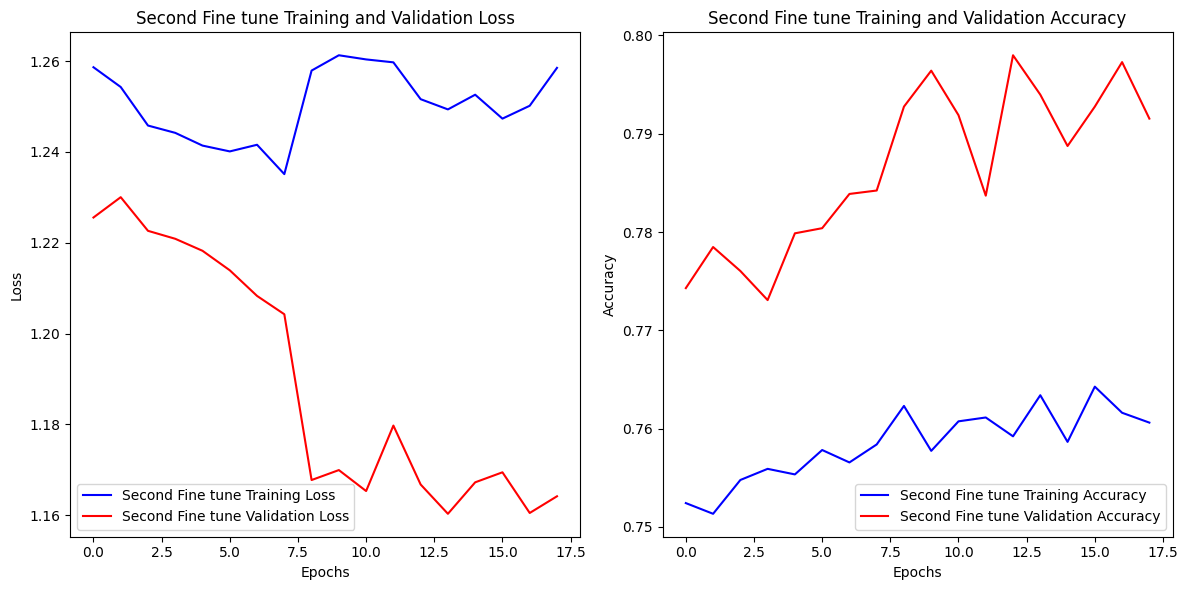

In [ ]:
import json
import matplotlib.pyplot as plt


# Load metrics from the JSON file
second_fine_tune_metrics_path = 'second_fine_tuned_emotion_training_metrics.json'
with open(second_fine_tune_metrics_path, 'r') as f:
    second_fine_tune_metrics = json.load(f)


# Extract the metrics
second_fine_tune_train_losses = second_fine_tune_metrics['second_fine_tune_train_losses']
second_fine_tune_val_losses = second_fine_tune_metrics['second_fine_tune_val_losses']
second_fine_tune_train_accuracies = second_fine_tune_metrics['second_fine_tune_train_accuracies']
second_fine_tune_val_accuracies = second_fine_tune_metrics['second_fine_tune_val_accuracies']

import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(second_fine_tune_train_losses, label='Second Fine tune Training Loss', color='blue')
plt.plot(second_fine_tune_val_losses, label='Second Fine tune Validation Loss', color='red')
plt.title('Second Fine tune Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(second_fine_tune_train_accuracies, label='Second Fine tune Training Accuracy', color='blue')
plt.plot(second_fine_tune_val_accuracies, label='Second Fine tune Validation Accuracy', color='red')
plt.title('Second Fine tune Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()


In [ ]:
import os

drive_path = 'folder'

second_fine_tune_checkpoint_path = os.path.join(drive_path, 'second_fine_tuned_emotion_checkpoint.pth')

if os.path.exists(second_fine_tune_checkpoint_path):
    checkpoint = torch.load(second_fine_tune_checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])



model.to(device)


<ipython-input-19-22430c4ee148>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(second_fine_tune_checkpoint_path, map_location=device)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
model.eval()
second_fine_tune_test_running_loss = 0.0
second_fine_tune_test_running_corrects = 0
second_fine_tune_test_running_precision = 0.0
second_fine_tune_test_running_recall = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        second_fine_tune_test_running_loss += loss.item() * inputs.size(0)
        second_fine_tune_test_running_corrects += accuracy(outputs, labels) * inputs.size(0)
        batch_precision, batch_recall = precision_recall(outputs, labels)
        second_fine_tune_test_running_precision += batch_precision * inputs.size(0)
        second_fine_tune_test_running_recall += batch_recall * inputs.size(0)

    test_loss = second_fine_tune_test_running_loss / len(test_dataset)
    test_acc = second_fine_tune_test_running_corrects / len(test_dataset)
    test_precision = second_fine_tune_test_running_precision / len(test_dataset)
    test_recall = second_fine_tune_test_running_recall / len(test_dataset)

print(f'Second Fine-tuning Test - Loss: {test_loss:.4f} Acc: {test_acc:.4f} Precision: {test_precision:.4f} Recall: {test_recall:.4f}')

Second Fine-tuning Test - Loss: 1.6094 Acc: 0.6516 Precision: 0.9989 Recall: 0.6516
